# ECSE-551 Mini Project 3
Authors:
* Ashley Meagher (260822930)
* Charles Sirois (261158513)  
* Emma ()

In [ ]:
# To specify where to load the data
in_colab = False

%load_ext autoreload
%autoreload 2

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as pltà

import pickle
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Colab setup
if in_colab:
    folder_path = 'drive/MyDrive/Colab Notebooks/ECSE 551_MP3'

    from google.colab import drive
    from google.colab import data_table

    data_table.enable_dataframe_formatter()  # For interactive df viz

    drive.mount('/content/drive')

    #   # Import LogisticRegression
    #   import sys
    #   sys.path.insert(0, folder_path)
    #   from LogisticRegression import LogisticRegression

else:
    folder_path = 'MP3'

    # Our imports
    # from LogisticRegression import LogisticRegression, cost_function
    ...

# Random seed
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Dataset

In [51]:
class MyDataset(Dataset):
    """To load the pickled data file. Class from tutorial 6 of ECSE-551

    img_file: the pickle file containing the images
    label_file: the .csv file containing the labels
    transform: We use it for normalizing images (see above)
    idx: This is a binary vector that is useful for creating training and validation set.
    
    It return only samples where idx is True.

    Attributes
    ----------
    data
    targets
    transform
    
    """
    def __init__(self, img_file_name, label_file_name=None, transform=None, idx = None, folder_path=None):
        img_file_name = f"{folder_path}/{img_file_name}"
        
        with open(img_file_name, 'rb') as img_file:
            self.data = pickle.load(img_file, encoding='bytes')

        if label_file_name is not None:
            label_file = f"{folder_path}/{label_file_name}"

            # labels_df = pd.read_excel(label_file)
            # self.targets = labels_df['class'].to_numpy()
            
            self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1)[:, 1:]
            
        else:
            self.targets = None

        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
          
        self.transform = transform

    def __len__(self):
        if self.targets is not None:
            l = len(self.targets) 
        else:
            l = self.data.shape[0]
        return l

    def __getitem__(self, index):
        img = self.data[index][0]
        target = int(self.targets[index])

        if self.transform is not None:
            # img = Image.fromarray(img.astype('float'), mode='L')
            img_trans = self.transform(img)

        # If not transform specified, transform to torch tensor
        else:
            img_trans = transforms.ToTensor()(img)


        return img_trans, target
    
def print_infos(dataset, img_idx=None):
    """To print information about the dataset.

    Shows image at img_idx or a random one if None.

    Args:
        img_idx (int, optional): Image to show. Defaults to None.
    """
    

    # General information
    print(f"Information about the dataset:")
    print(f"\tNumber of samples: {dataset.data.shape[0]}")
    print(f"\tFeature space: {dataset.data.shape[-2]}*{dataset.data.shape[-1]}")

    if dataset.targets is not None:
        classes, classes_count = np.unique(dataset.targets, return_counts=True)
        print(f"\tDifferent classes: {classes}. Their proportion: {classes_count/classes_count.sum()}")

    if img_idx is not None:
        print(f'Image {img_idx}')
        plt.imshow(dataset.data[img_idx, 0], cmap='gray', vmin=0, vmax=1)

    print()


def show_image(img, vmin=0, vmax=1, ax=None):
    """To show the image

    Args:
        img (Image): Image to show
        vmin (int, optional): Min value of the scale. Defaults to 0.
        vmax (int, optional): Max value of the scale. Defaults to 1.
    """
    # plt.imshow(img.cpu().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    
    if ax is not None:
        ax.imshow(img[0], cmap='gray', vmin=vmin, vmax=vmax)
        
    else:
        plt.imshow(img[0], cmap='gray', vmin=vmin, vmax=vmax)


# Load the dataset
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # transforms.Normalize((0.1307,), (0.3081,) #TODO: Find mean and var of dataset
])
# img_transform = None

data_folder = f"data"

train_file = 'Train.pkl'
train_label_file = 'Train_labels.csv'
test_file = 'Test.pkl'
val_size = 0.15

# Datasets
no_transform_ds = MyDataset(train_file, label_file_name=train_label_file, transform=None, folder_path=data_folder)
full_train_ds = MyDataset(train_file, label_file_name=train_label_file, transform=img_transform, folder_path=data_folder)
test_ds = MyDataset(test_file, transform=img_transform, folder_path=data_folder)

train_indices, val_indices, _, _ = train_test_split(
    range(len(full_train_ds)),
    full_train_ds.targets,
    stratify=full_train_ds.targets,
    test_size=val_size,
    random_state=random_seed
)

# generate subset based on indices
train_ds = Subset(full_train_ds, train_indices)
val_ds = Subset(full_train_ds, val_indices)

print(f'--- Full Train dataset ---')
print_infos(full_train_ds)

print(f'--- Test/Val Split ---')
print(f'Test size: {len(train_ds.indices)}')
print(f'Val size: {len(val_ds.indices)}')


print(f'\n--- Test dataset ---')
print_infos(test_ds)

--- Full Train dataset ---
Information about the dataset:
	Number of samples: 60000
	Feature space: 28*28
	Different classes: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]. Their proportion: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

--- Test/Val Split ---
Test size: 51000
Val size: 9000
--- Test dataset ---
Information about the dataset:
	Number of samples: 10000
	Feature space: 28*28



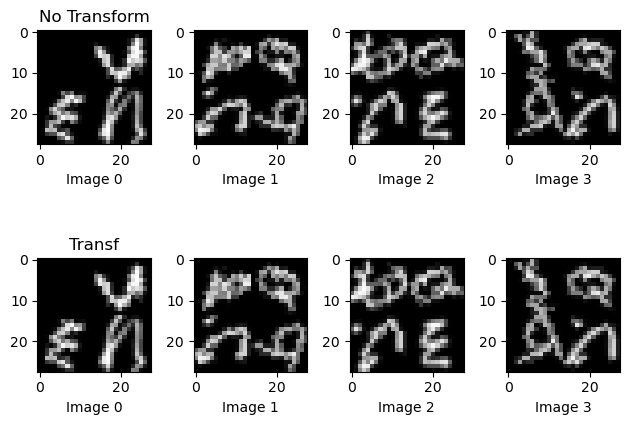

In [52]:
# Look a the first k images. Compare with and w/o transform
k = 4
fig, axes = plt.subplots(2, 4)
row_titles = ['No Transform', 'Transf']

for i, ax in enumerate(axes.flat):
    row = i // 4  # Calculate the row index
    col = i % 4  # Calculate the column index
    if row == 0:
        img, _ = no_transform_ds[col]
        vmin, vmax = 0, 1
    else:
        img, _ = full_train_ds[col]
        vmin, vmax = -1, 1

    show_image(img, ax=ax, vmin=vmin, vmax=vmax)

    if col == 0:
        ax.set_title(row_titles[row])  # Set row-wise title for the first image in each row
    ax.set_xlabel(f'Image {col}')  # Set individual title for each image

plt.tight_layout()
plt.show()

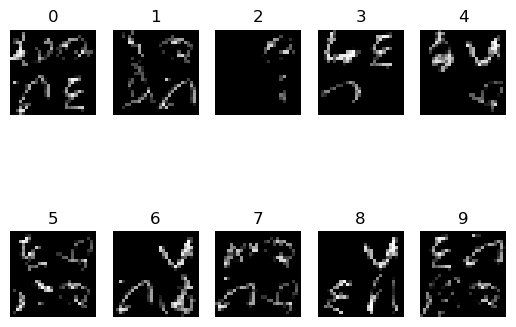

In [53]:
# Find the different labels
labels, labels_idx = np.unique(full_train_ds.targets, return_index=True)

fig = plt.figure()
plt.tight_layout()
for (i, label), idx in zip(enumerate(labels), labels_idx):
    # print(f'{i} {label} {idx}')
    img, target = full_train_ds[idx]

    ax = plt.subplot(2, 5, i + 1)
    ax.set_title(f'{target}')
    ax.axis('off')
    show_image(img)

plt.show()

In [56]:
# Dataloader
batch_size_train = 64
batch_size_test = 1000
train_dl = DataLoader(train_ds, batch_size=batch_size_train, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size_test, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size_test, shuffle=True)

# # Example, to go through all samples
# num_epochs=2 # Feel free to change it
# for epoch in range(num_epochs):
#     for train_data in val_dl: # train_data: One batch
#         [img,label] = train_data  # img: Size batch_size x 1 x 28 x28, label: batch_size

# With my laptop: Takes 12 seconds to run 2 epoch w/ batch size of 256

## Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [73]:
# Hyperparameters
n_epochs = 5
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [58]:
class Net(nn.Module):
    # This part defines the layers
    def __init__(self):
        super(Net, self).__init__()
        # At first there is only 1 channel (greyscale). The next channel size will be 10.
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # Then, going from channel size (or feature size) 10 to 20.
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # Now let us create some feed foreward layers in the end. Remember the sizes (from 320 to 50)
        self.fc1 = nn.Linear(320, 50)
        # The last layer should have an output with the same dimension as the number of classes
        self.fc2 = nn.Linear(50, 10)

    # And this part defines the way they are connected to each other
    # (In reality, it is our foreward pass)
    def forward(self, x):


        # F.relu is ReLU activation. F.max_pool2d is a max pooling layer with n=2
        # Max pooling simply selects the maximum value of each square of size n. Effectively dividing the image size by n
        # At first, x is out input, so it is 1x28x28
        # After the first convolution, it is 10x24x24 (24=28-5+1, 10 comes from feature size)
        # After max pooling, it is 10x12x12
        # ReLU doesn't change the size
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # Again, after convolution layer, size is 20x8x8 (8=12-5+1, 20 comes from feature size)
        # After max pooling it becomes 20x4x4
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        # This layer is an imaginary one. It simply states that we should see each member of x
        # as a vector of 320 elements, instead of a tensor of 20x4x4 (Notice that 20*4*4=320)
        x = x.view(-1, 320)

        # Feedforeward layers. Remember that fc1 is a layer that goes from 320 to 50 neurons
        x = F.relu(self.fc1(x))

        # Output layer
        x = self.fc2(x)

        # We should put an appropriate activation for the output layer.
        return F.log_softmax(x)

In [74]:
# Intitializations
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# To keep track of the progress
train_losses = []
train_counter = []
val_losses = []
val_accs = []
val_counter = [0]  # When the test function is called

In [75]:
def train(epoch):
  """Perform training for one epoch.   

  Args:
      epoch (_type_): _description_
  """
  network.train()

  # For each batch
  for batch_idx, (data, target) in enumerate(train_dl):
    optimizer.zero_grad()  # Set gradients to 0
    output = network(data)
    loss = F.nll_loss(output, target)  # negative log liklhood loss
    loss.backward()  # Compute 
    optimizer.step()

    if batch_idx % log_interval == 0:
      print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_dl.dataset)} ({100. * batch_idx / len(train_dl):.0f}%)]\tLoss: {loss.item():.6f}')
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*batch_size_train) + ((epoch-1)*len(train_dl.dataset))) # Total num of samples seen
      torch.save(network.state_dict(), f'models/model.pth')
      torch.save(optimizer.state_dict(), f'models/optimizer.pth')

def validate():
  """
  Check acc on validation 
  """
  network.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_dl:
      output = network(data)
      val_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  val_loss /= len(val_dl.dataset)
  acc = 100. * correct / len(val_dl.dataset)
  val_losses.append(val_loss)
  val_accs.append(acc)
  print(f'\nTest set: Avg. loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_dl.dataset)} ({acc:.0f}%)\n')

In [76]:
validate()
for epoch in range(1, n_epochs + 1):
  val_counter.append(epoch*len(train_dl.dataset))
  train(epoch)
  validate()



Test set: Avg. loss: 2.3080, Accuracy: 899/9000 (10%)

Train Epoch: 1 [0/51000 (0%)]	Loss: 2.307110
Train Epoch: 1 [640/51000 (1%)]	Loss: 2.308990
Train Epoch: 1 [1280/51000 (3%)]	Loss: 2.305977
Train Epoch: 1 [1920/51000 (4%)]	Loss: 2.307919
Train Epoch: 1 [2560/51000 (5%)]	Loss: 2.313625
Train Epoch: 1 [3200/51000 (6%)]	Loss: 2.302696
Train Epoch: 1 [3840/51000 (8%)]	Loss: 2.310799
Train Epoch: 1 [4480/51000 (9%)]	Loss: 2.310687
Train Epoch: 1 [5120/51000 (10%)]	Loss: 2.303236
Train Epoch: 1 [5760/51000 (11%)]	Loss: 2.301519
Train Epoch: 1 [6400/51000 (13%)]	Loss: 2.301604
Train Epoch: 1 [7040/51000 (14%)]	Loss: 2.303907
Train Epoch: 1 [7680/51000 (15%)]	Loss: 2.310638
Train Epoch: 1 [8320/51000 (16%)]	Loss: 2.293758
Train Epoch: 1 [8960/51000 (18%)]	Loss: 2.305861
Train Epoch: 1 [9600/51000 (19%)]	Loss: 2.295825
Train Epoch: 1 [10240/51000 (20%)]	Loss: 2.297459
Train Epoch: 1 [10880/51000 (21%)]	Loss: 2.307509
Train Epoch: 1 [11520/51000 (23%)]	Loss: 2.301989
Train Epoch: 1 [12160/

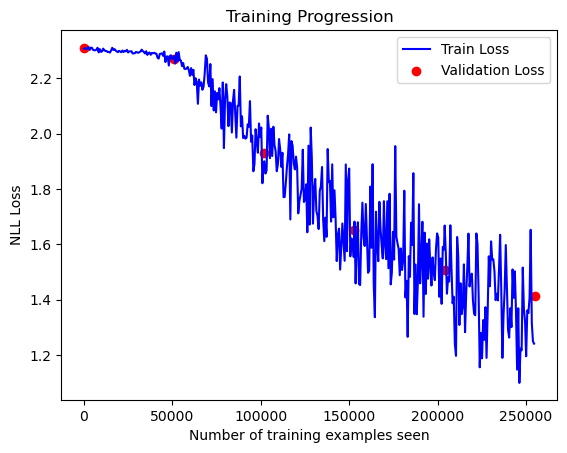

In [77]:
# Plot training progression
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(val_counter, val_losses, color='red')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('NLL Loss')
plt.title('Training Progression')
plt.show()